## Description of notebook

In this notebook, an usupervised bias detection tool is applied on synthetic data of the CUB process from 2014. The synthetic dataset (n=20.000) reflects group level characteristics of students that were registered to receive a college grant on 01-02-2014 by the Dutch Executive Education Agency (DUO). A clustering algorithm is applied to identify groups of similar students that are treated differently.

## Table of contents

0. Import libraries and data
1. Data processing
2. Clustering
3. Analysis of cluster with most bias
4. Analysis of all identifief clusters

## 0. Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_function import diff_df
from unsupervised_bias_detection.clustering import BiasAwareHierarchicalKMeans

df = pd.read_csv('../data/twitter1516_final.csv')
df = df.drop(columns=['tweet_id','tweet'])
df.head()


,label,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score
0,1,95,2,0,0,1,15375121,72.567469,-0.3182
1,1,118,1,1,0,1,3673898,55.294333,0.8398
2,0,133,0,0,1,1,1274260,32.033388,-0.7269
3,1,96,1,0,0,1,13955752,64.548896,-0.3400
4,1,96,2,0,0,1,189683,24.726166,0.0000


In [2]:
df.shape

(1057, 9)

## 1. Data processing

In [3]:
# performance metric
targetColumn = 'label'

# feature columns
X = df.drop(columns=[targetColumn])
features = X.columns.to_list()

# target column in df
y = df[targetColumn]

## 2. Clustering

In [4]:
#clustering paramters 
n_iter=10
min_cluster_size=15

# clustering
hbac = BiasAwareHierarchicalKMeans(n_iter=n_iter, min_cluster_size=min_cluster_size).fit(X, y)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but BiasAwareHierarchicalKMeans was fitted without feature names
  warnings.warn(


In [5]:
# UI text
print(f'Parameters selected\nNumber of iterations: {n_iter}\nMinimal cluster size: {min_cluster_size}')

Parameters selected
Number of iterations: 10
Minimal cluster size: 15


In [6]:
# json export
hbac.n_iter
hbac.min_cluster_size

15

In [7]:
# assign cluster labels to the original dataframe
df['Cluster'] = hbac.labels_

# cluster with most bias has label 0
df_most_biased_cluster = df[hbac.labels_ == 0]
df_other = df[hbac.labels_ != 0]

# UI text
print(f'We found {hbac.n_clusters_} clusters.\nCluster with most bias consists of {len(df_most_biased_cluster)} datapoints. The uploaded dataset consists of {df.shape[0]} datapoints.')

# json export
hbac.n_clusters_
hbac.labels_
hbac.scores_

We found 10 clusters.
Cluster with most bias consists of 175 datapoints. The uploaded dataset consists of 1057 datapoints.


array([ 0.13882086,  0.10315989,  0.09110787,  0.06217962,  0.04255814,
        0.0403618 , -0.00340317, -0.07378521, -0.15256795, -0.17663956])

## 3. Cluster analysis

### 3a. Most deviating cluster vs rest of dataset

In [8]:
# df with all differences
diff_df = diff_df(df, features, type='Numerical')
diff_df

,Difference
length,-1.84317
#URLs,0.13583
#mentions,-0.06150
#hashs,-0.23043
verified,0.31746
#followers,10098678.88503
user_engagement,34.83402
sentiment_score,0.02686


In [9]:
# UI text 
print('In the most biased cluster datapoints have:')
for feat in features:
    diff = diff_df.loc[feat,"Difference"].round(2)
    if diff < 0:
        print(f'{abs(diff)} less {feat} than in the rest of the dataset.')
    elif diff > 0:
        print(f'{diff} more {feat} than in the rest of the dataset.')
    elif diff == 0:
        print(f'equal {feat} as in the rest of the dataset.')

In the most biased cluster datapoints have:
1.84 less length than in the rest of the dataset.
0.14 more #URLs than in the rest of the dataset.
0.06 less #mentions than in the rest of the dataset.
0.23 less #hashs than in the rest of the dataset.
0.32 more verified than in the rest of the dataset.
10098678.89 more #followers than in the rest of the dataset.
34.83 more user_engagement than in the rest of the dataset.
0.03 more sentiment_score than in the rest of the dataset.


## 4. Analysis of all identified clusters

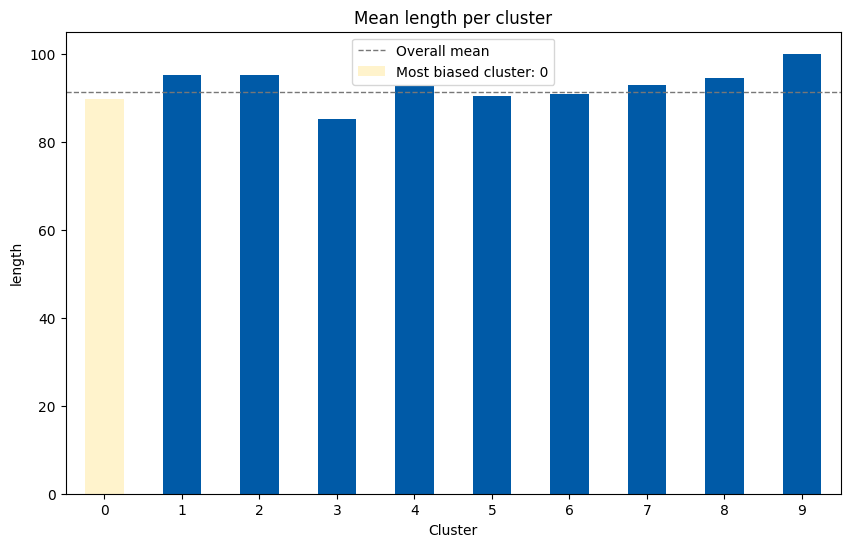

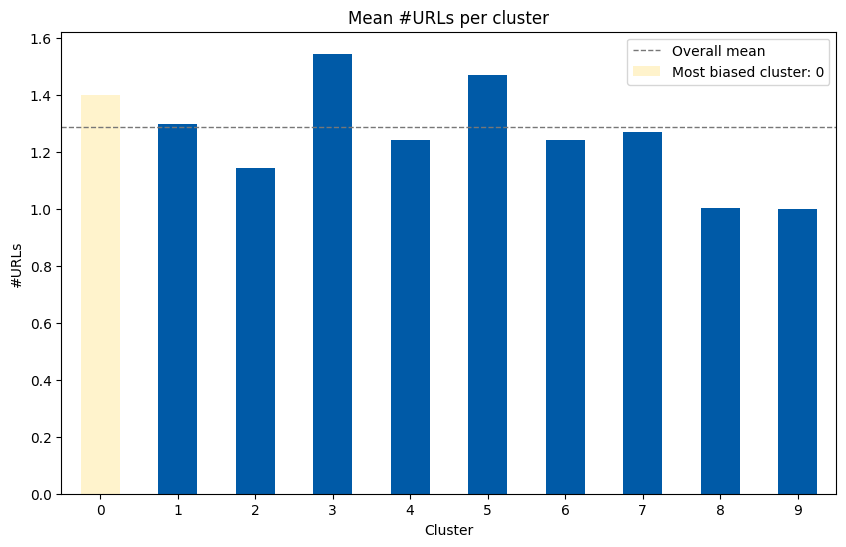

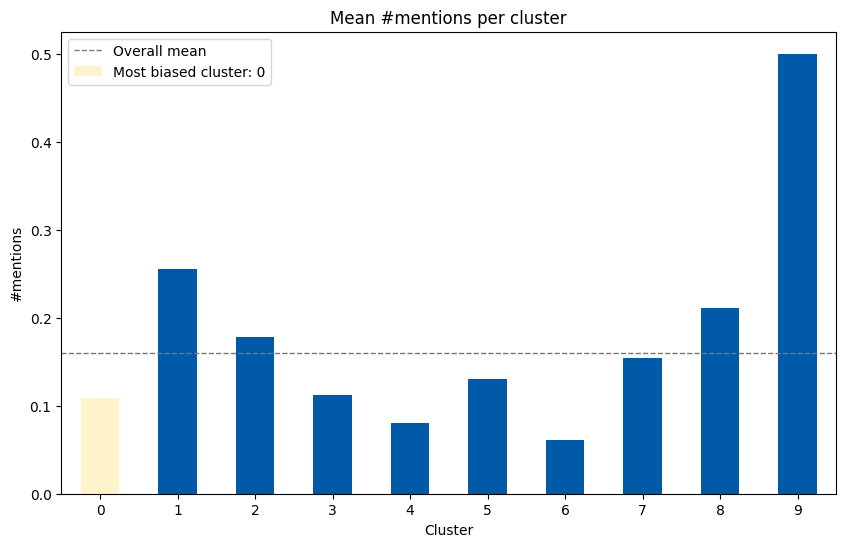

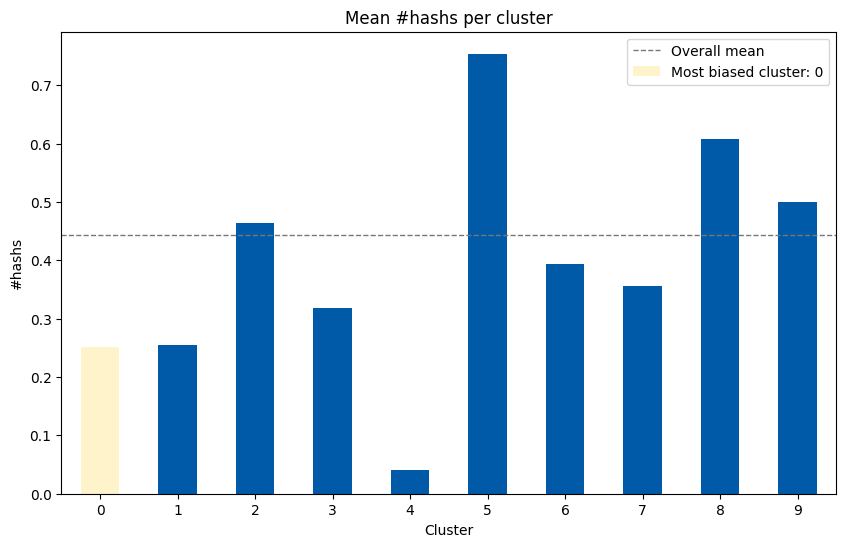

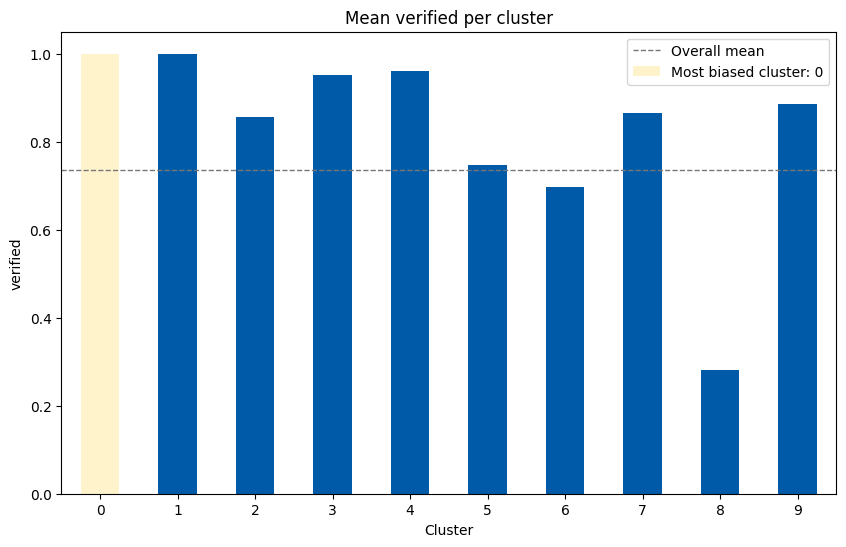

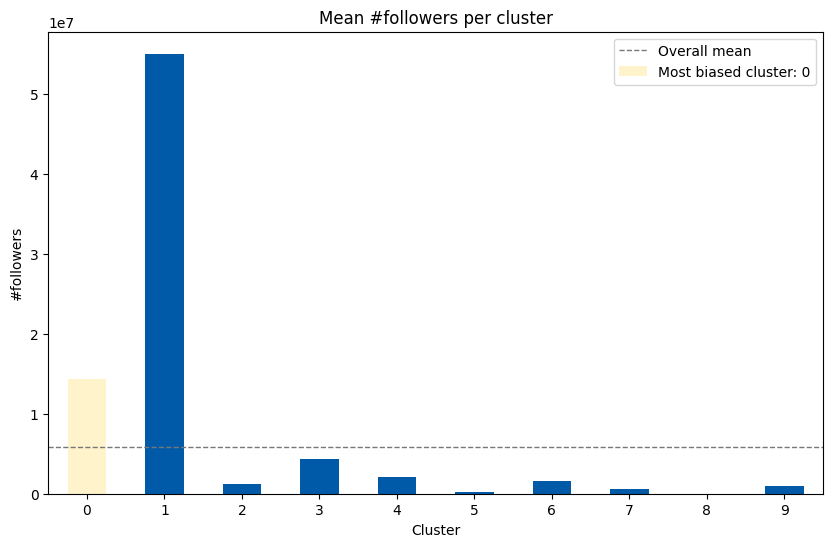

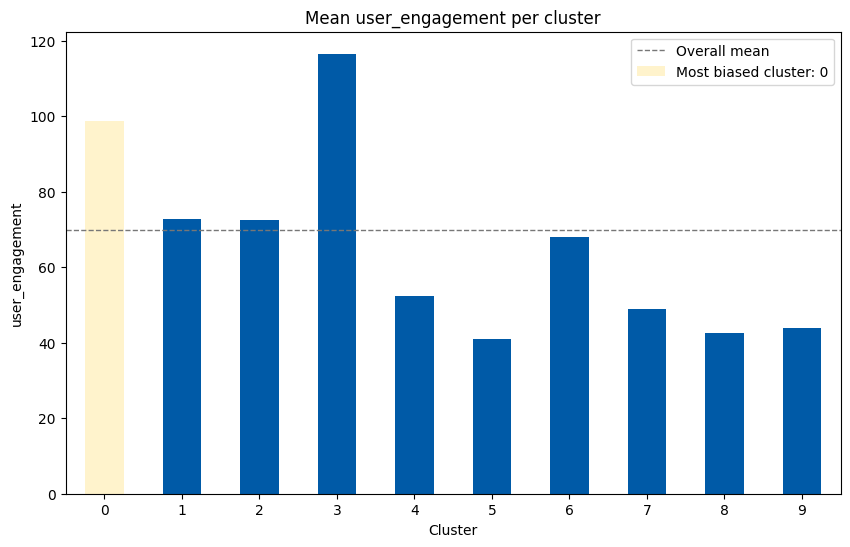

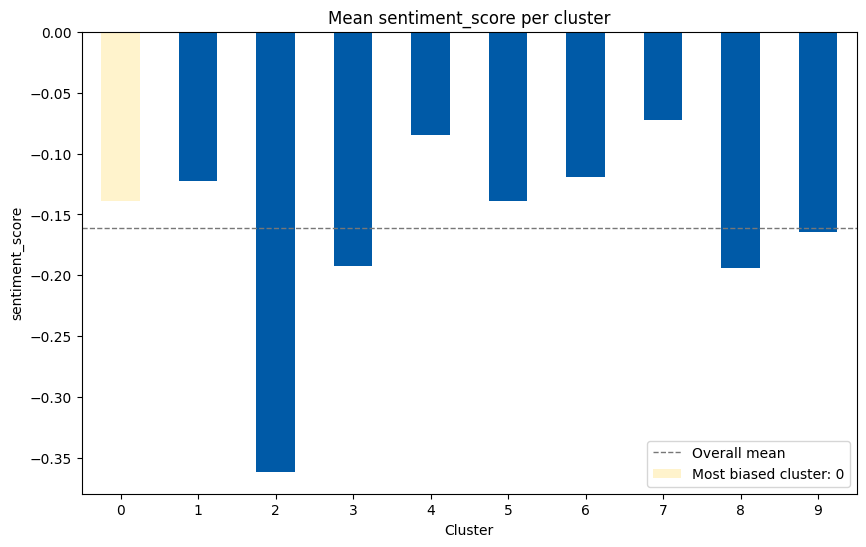

In [10]:
# Plot bar charts of features in df per cluster in separate plots
for feature in features:
    plt.figure(figsize=(10, 6))
    bars = df.groupby('Cluster')[feature].mean().plot(kind='bar', color=['#fff3cc' if i == 0 else '#005AA7' for i in range(hbac.n_clusters_)])
    plt.title(f'Mean {feature} per cluster')
    plt.xticks(rotation=0)
    plt.xlabel('Cluster')
    plt.axhline(y=df[feature].mean(), color='#777', linestyle='--', linewidth=1)
    bars.legend(['Overall mean','Most biased cluster'])
    plt.ylabel(f'{feature}')
    plt.show()